In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

In [2]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=10)

env = env_creator()
nb_actions = env.action_space.n

def buildModel():
    # Next, we build a very simple model.
    model = Sequential()

    #model.add(Conv2D(input_shape=(1,10,2), filters=32, kernel_size=(4,2), padding='same'))
    #model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same'))
    #model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
    #model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
    #model.add(Flatten())
    model.add(Flatten(input_shape=(1,10,2)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model
buildModel().summary()
def agent_creator():
    #processor = EnvProcessor()
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=1024, window_length=1)
    #policy = EpsGreedyQPolicy()
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, enable_double_dqn=False)
    agent.compile(Adam(lr=0.01), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              21504     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 2,122,754
Trainable params: 2,122,754
Non-trainable params: 0
_________________________________________________________________


starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
155/989 [===>..........................] - ETA: 5s - reward: -0.5368 - cumulative_reward: -105.7826WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 44s 45ms/step - reward: -10.5246 - cumulative_reward: -86.0412
train 1 completed. took 45.986 seconds, total_reward: -24.299999999871922 total_profit: 0.739771395614826
min reward: -191.5, max reward: 123.29999999999953, mean_reward: -0.004910082844993316


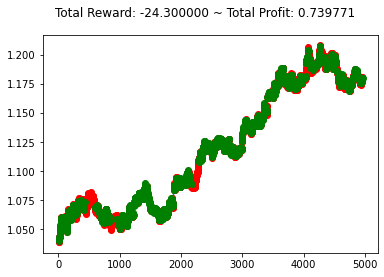

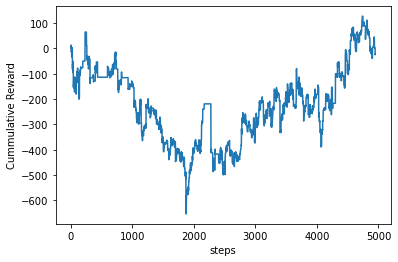

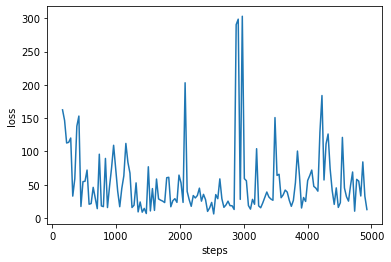

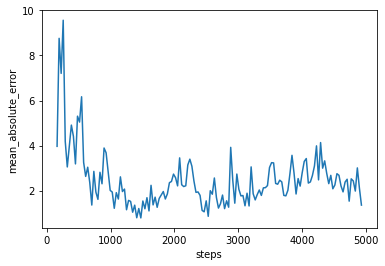

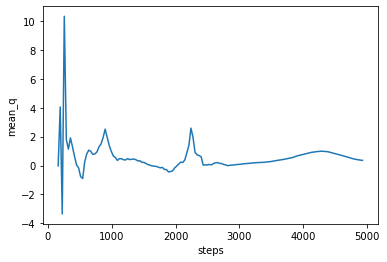

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 45s 46ms/step - reward: -11.0794 - cumulative_reward: 288.2792
train 2 completed. took 95.156 seconds, total_reward: 1010.1999999999824 total_profit: 0.7748181805044937
min reward: -188.70000000000164, max reward: 128.29999999999896, mean_reward: 0.20412204485754343


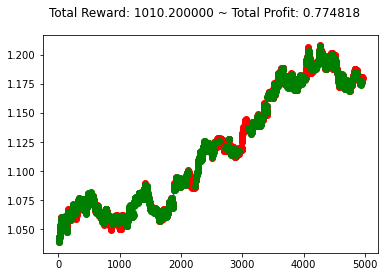

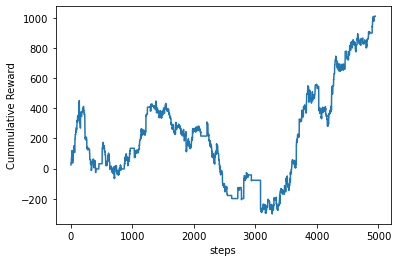

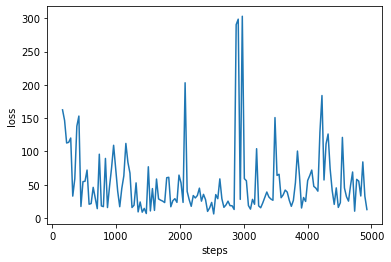

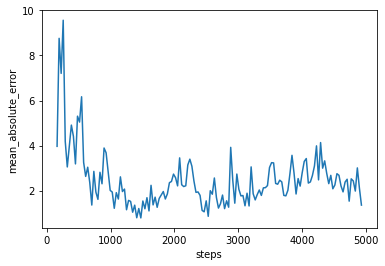

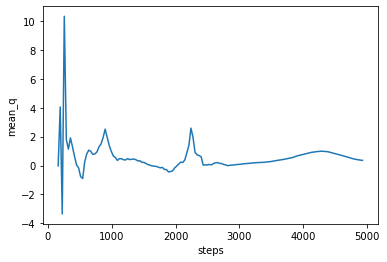

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 47s 47ms/step - reward: -14.7009 - cumulative_reward: 80.5268
train 3 completed. took 146.242 seconds, total_reward: 296.0000000001333 total_profit: 0.7587259952873847
min reward: -118.00000000000033, max reward: 261.5999999999996, mean_reward: 0.05981006263894389


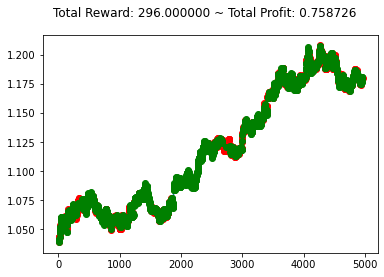

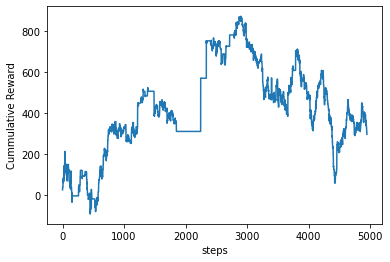

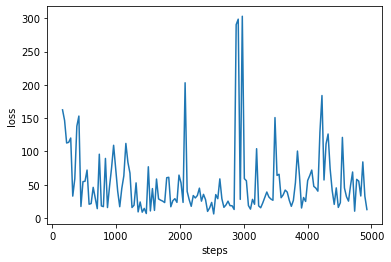

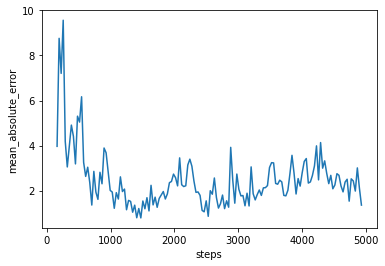

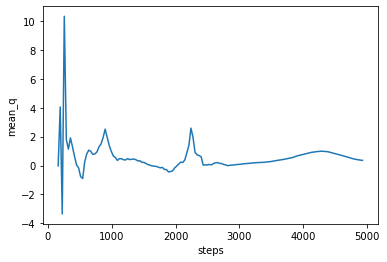

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 48s 48ms/step - reward: 33.4971 - cumulative_reward: -301.5354: 1:12 - reward: 90
train 4 completed. took 198.127 seconds, total_reward: -794.7000000000702 total_profit: 0.6813921497031478
min reward: -191.59999999999843, max reward: 121.6000000000017, mean_reward: -0.16057789452416046


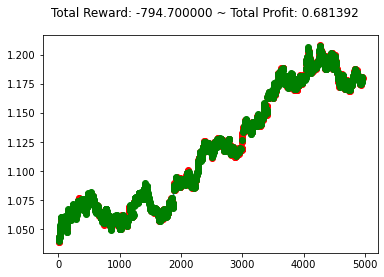

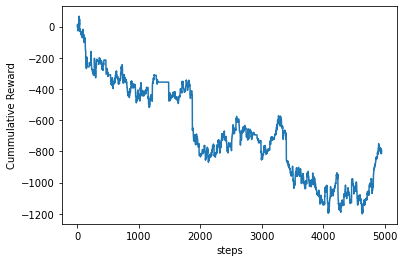

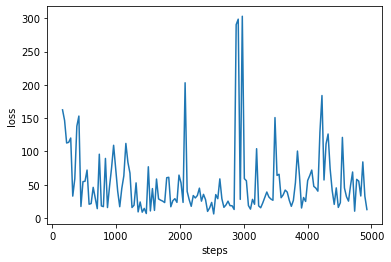

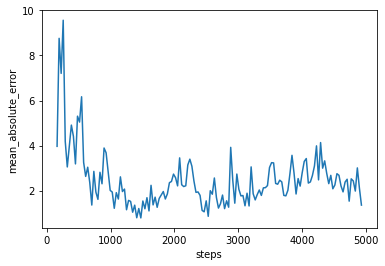

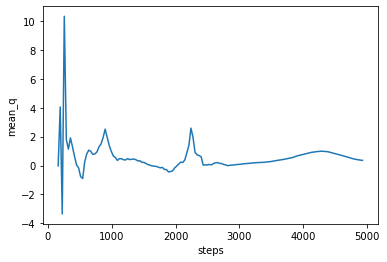

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 50s 50ms/step - reward: -13.6495 - cumulative_reward: -222.6723
train 5 completed. took 252.367 seconds, total_reward: -444.9000000001015 total_profit: 0.774189343514327
min reward: -598.9000000000023, max reward: 137.7000000000006, mean_reward: -0.08989694887858184


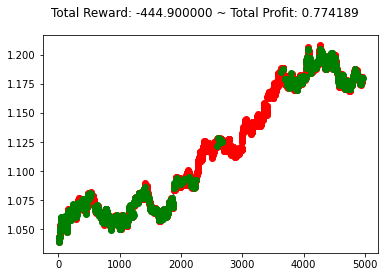

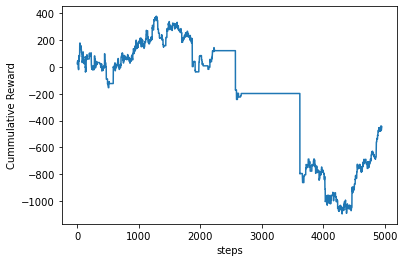

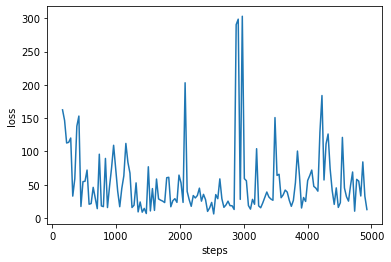

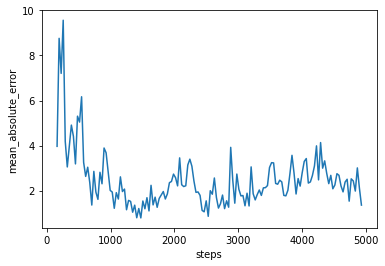

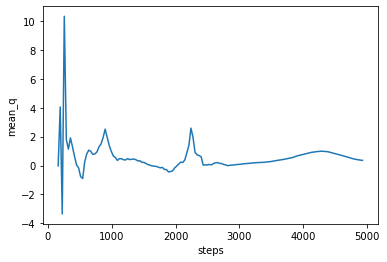

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 48s 49ms/step - reward: -29.8391 - cumulative_reward: 331.4213
train 6 completed. took 305.640 seconds, total_reward: 357.2000000001392 total_profit: 0.732512062084384
min reward: -128.39999999999964, max reward: 170.40000000000165, mean_reward: 0.07217619721158601


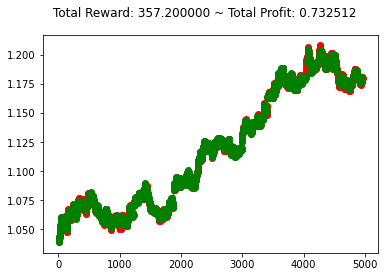

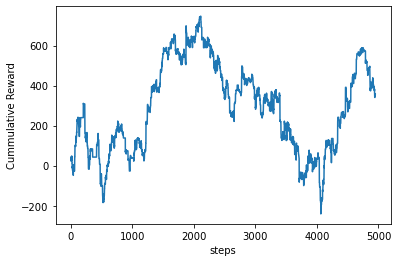

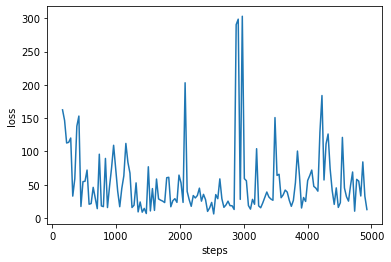

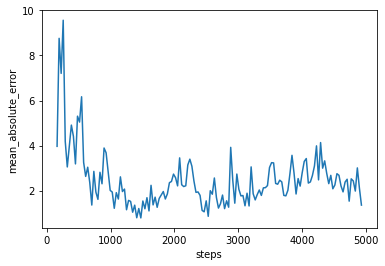

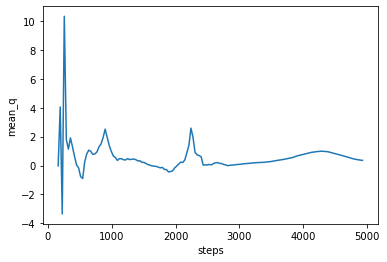

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 50s 50ms/step - reward: -11.8424 - cumulative_reward: -244.03346s - reward: -13.243
train 7 completed. took 360.458 seconds, total_reward: -140.90000000009067 total_profit: 0.7307534739636531
min reward: -180.79999999999873, max reward: 204.40000000000015, mean_reward: -0.028470398060232507


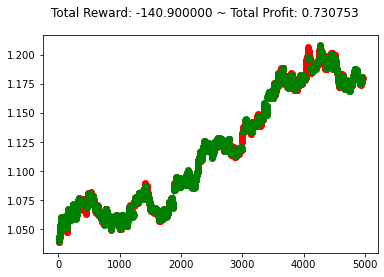

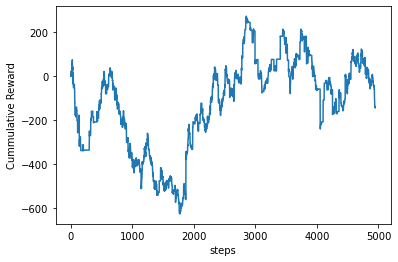

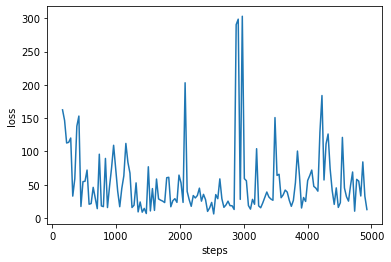

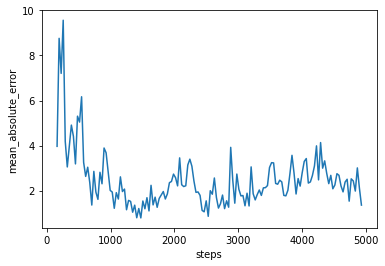

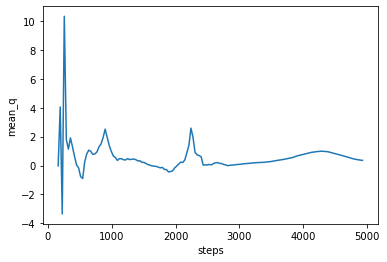

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 50s 51ms/step - reward: 3.9612 - cumulative_reward: 256.5826
train 8 completed. took 416.146 seconds, total_reward: 357.4999999999859 total_profit: 0.7256575558013785
min reward: -170.40000000000165, max reward: 126.29999999999919, mean_reward: 0.07223681551828368


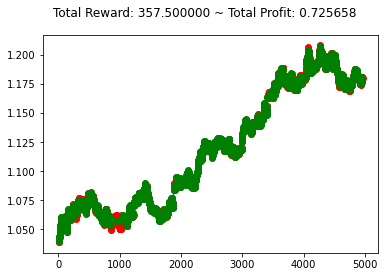

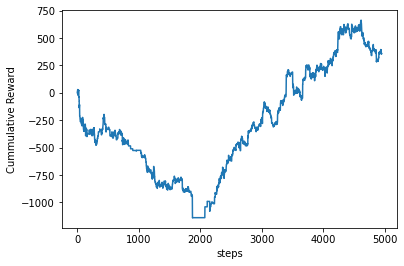

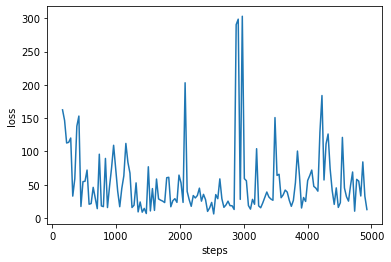

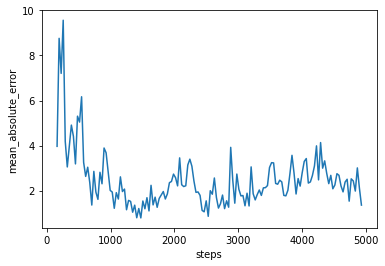

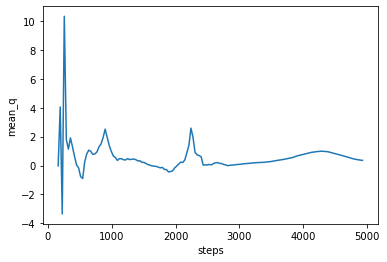

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 52s 52ms/step - reward: 13.9110 - cumulative_reward: 482.2760
train 9 completed. took 474.182 seconds, total_reward: 703.6999999999543 total_profit: 0.7858626097098143
min reward: -168.70000000000164, max reward: 179.10000000000093, mean_reward: 0.14219034148311868


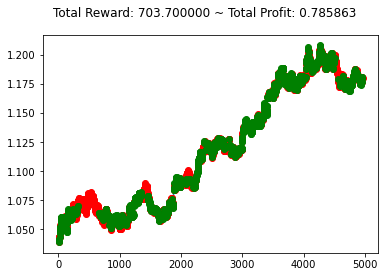

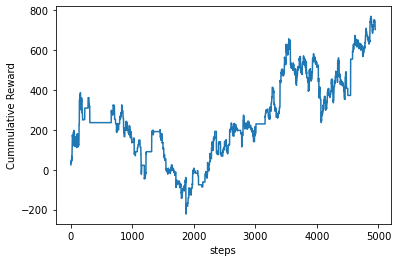

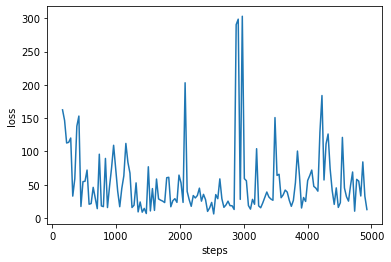

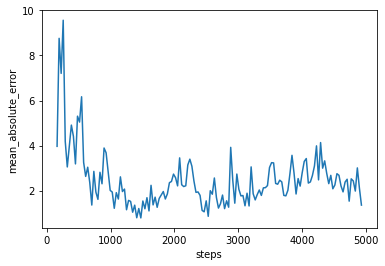

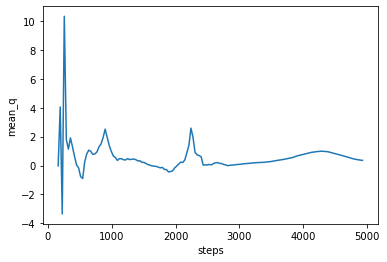

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 60s 61ms/step - reward: -0.3202 - cumulative_reward: -757.5718
train 10 completed. took 539.878 seconds, total_reward: -1009.7999999999379 total_profit: 0.701832430464852
min reward: -195.19999999999982, max reward: 128.39999999999964, mean_reward: -0.2040412204485629


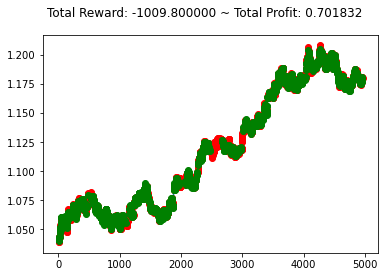

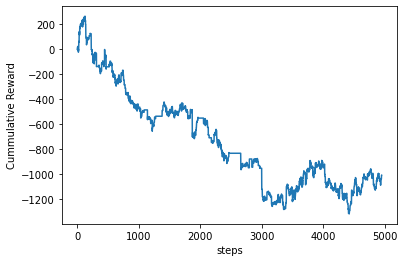

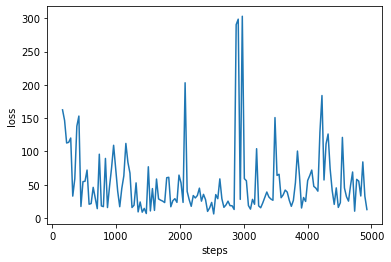

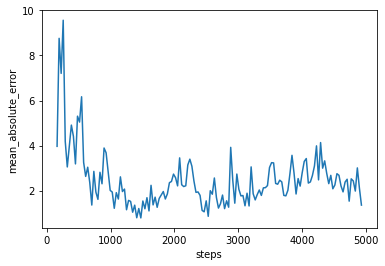

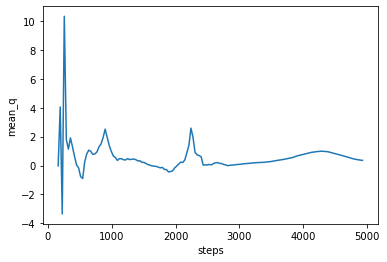

In [3]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="dqn")
e.train(repeat=10)


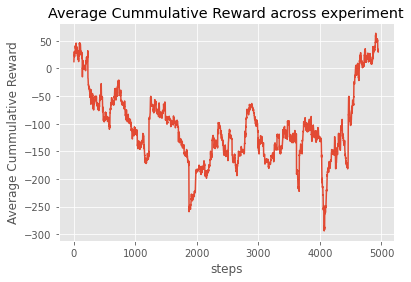

In [4]:
e.process_train_result()

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
192/199 [===========================>..] - ETA: 0s - reward: 0.0000e+00 - cumulative_reward: 0.0000e+00Episode 1: reward: 0.000, steps: 999

test completed. total_reward: 0.0 total_profit: 1.0040589181323873
min reward: 0.0, max reward: 0.0, mean_reward: 0.0



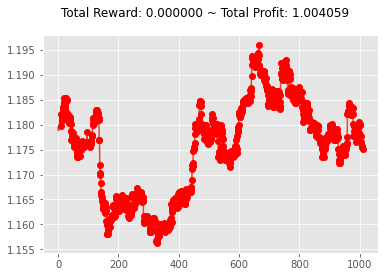

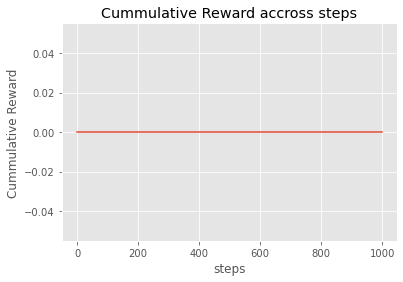

In [5]:
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10))

In [6]:
def agent_creator():
    #processor = EnvProcessor()
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=1024, window_length=1)
    #policy = EpsGreedyQPolicy()
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, enable_double_dqn=True)
    agent.compile(Adam(lr=0.01), metrics=['mae'])
    return agent

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 58s 59ms/step - reward: -17.4254 - cumulative_reward: 65.3708
train 1 completed. took 61.815 seconds, total_reward: 667.7000000000111 total_profit: 0.8110877661334622
min reward: -260.7000000000004, max reward: 168.70000000000164, mean_reward: 0.1349161446756943


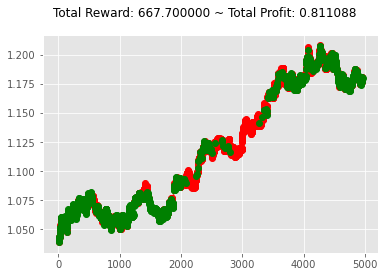

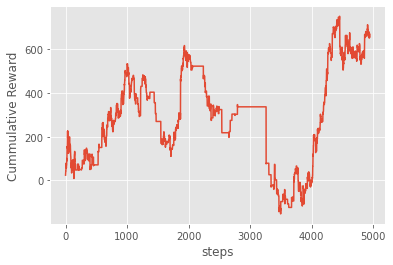

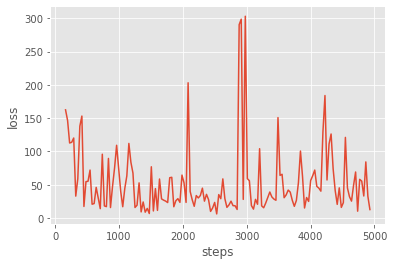

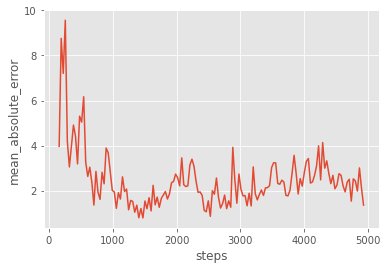

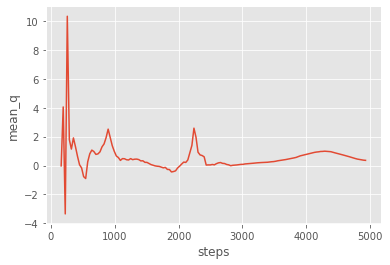

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 60s 61ms/step - reward: -2.5574 - cumulative_reward: -718.7162
train 2 completed. took 128.852 seconds, total_reward: -1442.4999999998422 total_profit: 0.6781166771739967
min reward: -104.99999999999955, max reward: 120.70000000000248, mean_reward: -0.29147302485347387


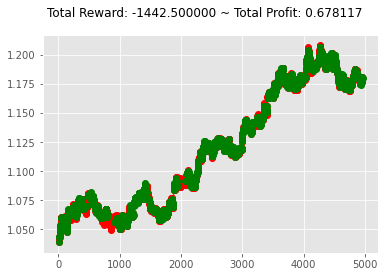

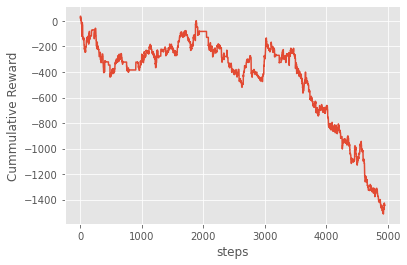

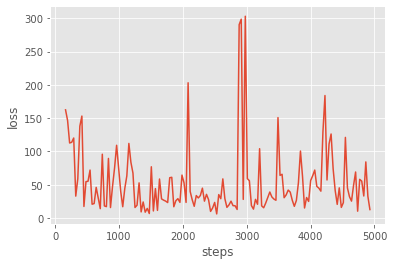

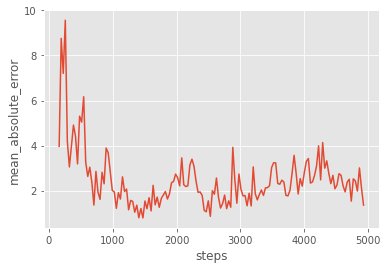

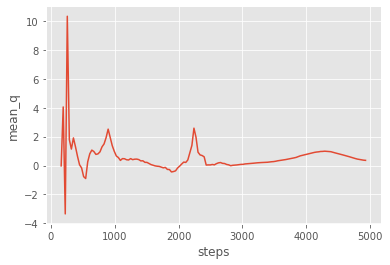

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 59s 59ms/step - reward: 11.4221 - cumulative_reward: 692.0639
train 3 completed. took 194.561 seconds, total_reward: 912.6999999999482 total_profit: 0.7849875335250377
min reward: -81.59999999999945, max reward: 194.9000000000023, mean_reward: 0.1844210951707311


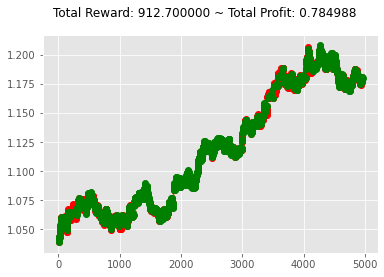

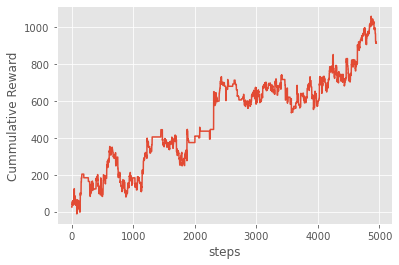

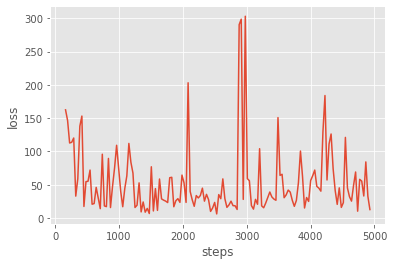

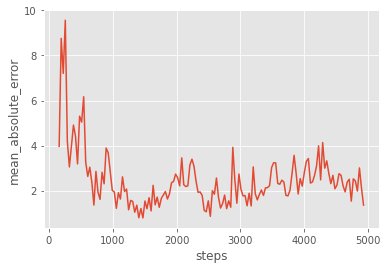

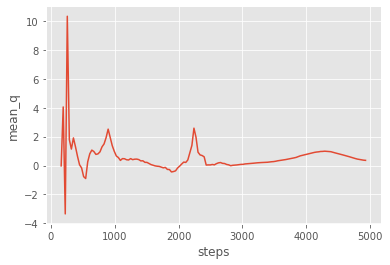

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 66s 66ms/step - reward: -28.2344 - cumulative_reward: 394.5626
train 4 completed. took 267.646 seconds, total_reward: 262.9000000000062 total_profit: 0.7268963988217348
min reward: -93.90000000000231, max reward: 233.60000000000048, mean_reward: 0.0531218427965258


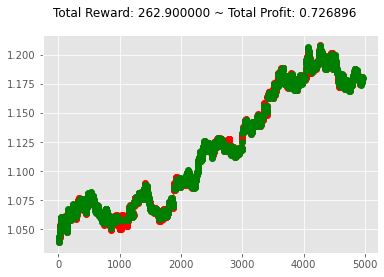

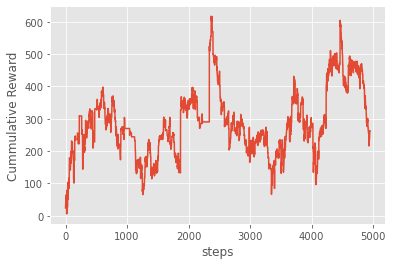

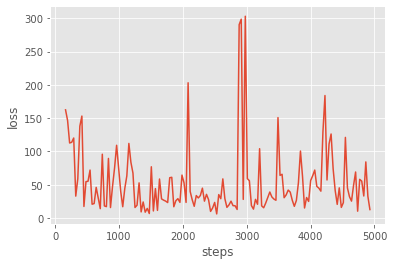

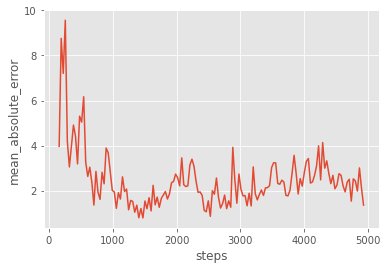

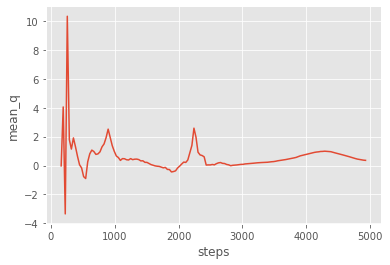

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 65s 66ms/step - reward: -1.2192 - cumulative_reward: -377.8580 10s - reward: -1.3327 - 
train 5 completed. took 340.906 seconds, total_reward: -1206.799999999973 total_profit: 0.7551961403722837
min reward: -655.2000000000003, max reward: 121.59999999999948, mean_reward: -0.24384724186703838


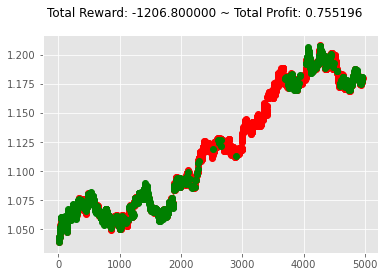

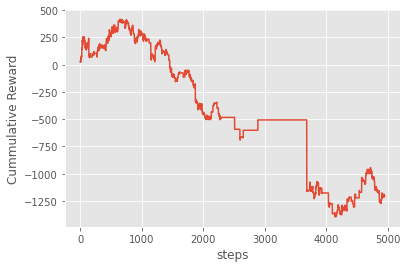

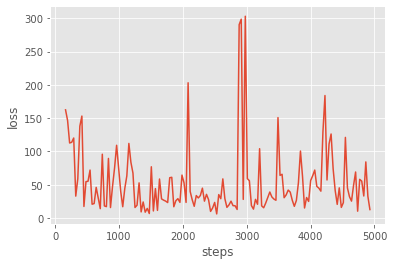

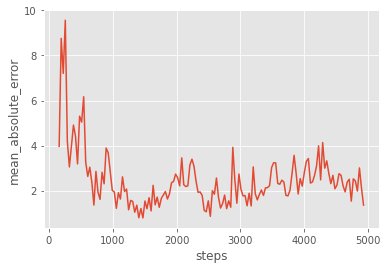

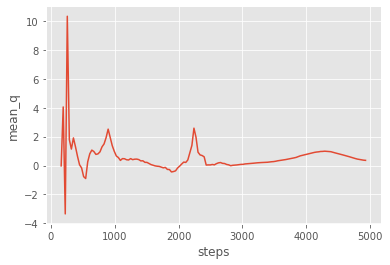

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 79s 79ms/step - reward: 7.2527 - cumulative_reward: 681.4914
train 6 completed. took 431.724 seconds, total_reward: 1239.8999999999796 total_profit: 0.7512497759737203
min reward: -105.20000000000084, max reward: 168.10000000000213, mean_reward: 0.25053546170943214


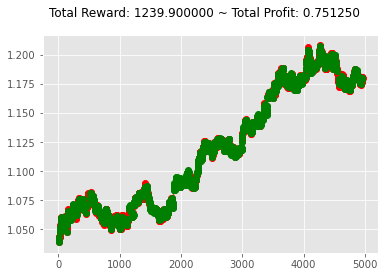

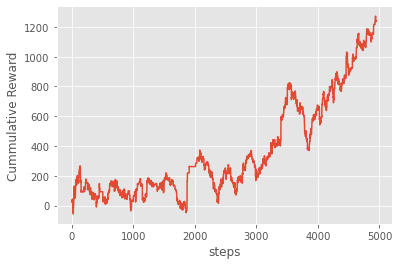

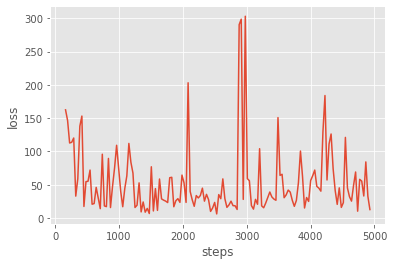

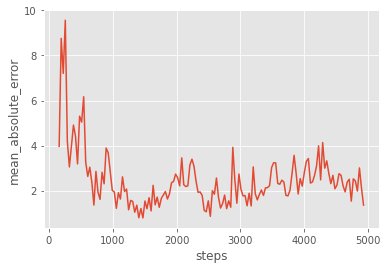

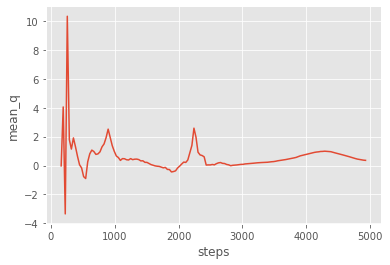

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 74s 75ms/step - reward: -1.0990 - cumulative_reward: -876.8071
train 7 completed. took 516.084 seconds, total_reward: -1087.8000000000236 total_profit: 0.7163583203250924
min reward: -152.49999999999986, max reward: 311.9999999999989, mean_reward: -0.21980198019802458


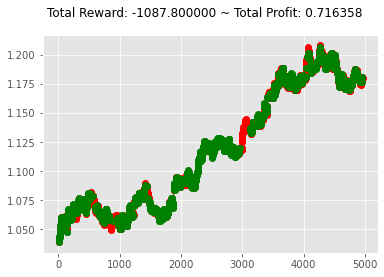

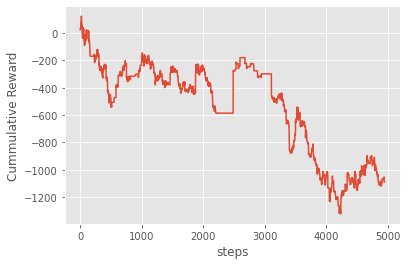

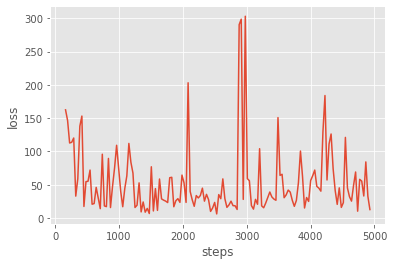

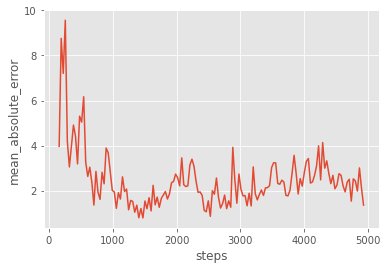

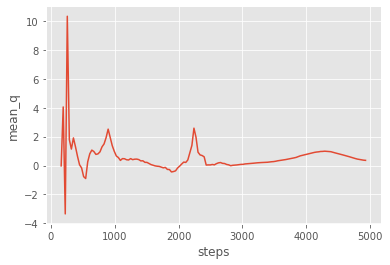

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 71s 72ms/step - reward: -14.4365 - cumulative_reward: -899.3276
train 8 completed. took 597.398 seconds, total_reward: -1223.9000000001051 total_profit: 0.710187218751812
min reward: -140.89999999999935, max reward: 116.19999999999963, mean_reward: -0.24730248535059712


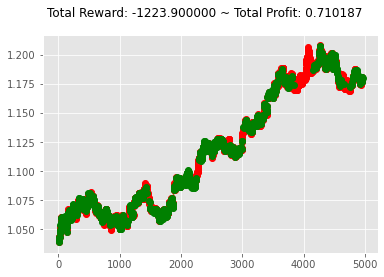

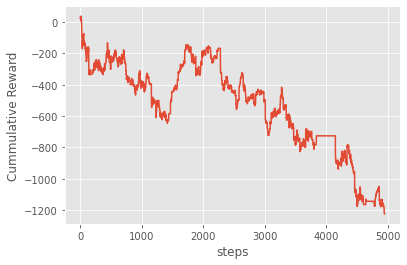

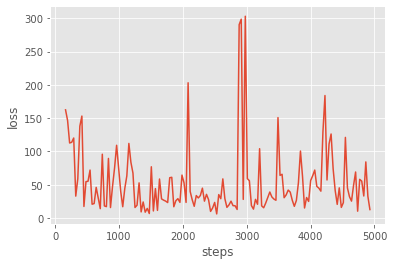

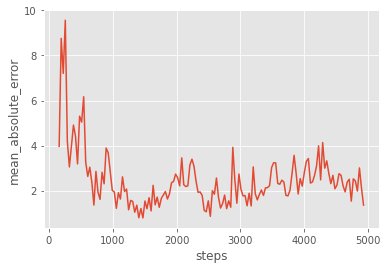

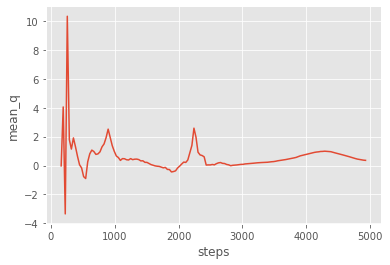

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 118s 119ms/step - reward: -9.5156 - cumulative_reward: 503.7082
train 9 completed. took 725.211 seconds, total_reward: 974.3999999999445 total_profit: 0.7771237282484463
min reward: -196.00000000000063, max reward: 191.59999999999843, mean_reward: 0.19688826025458567


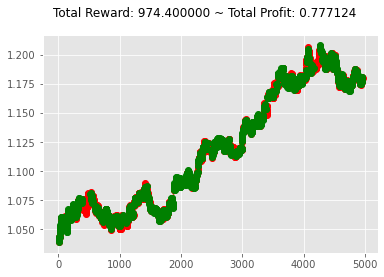

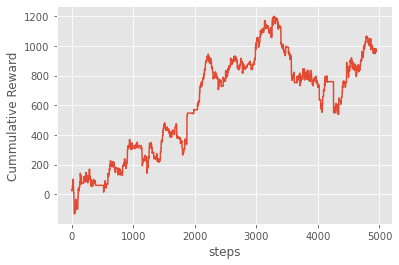

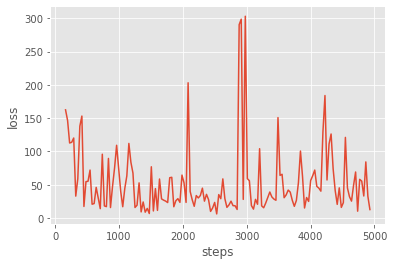

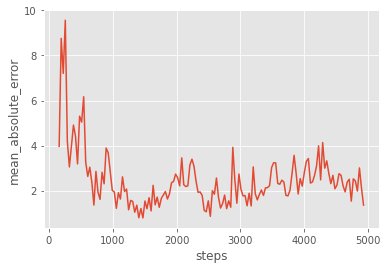

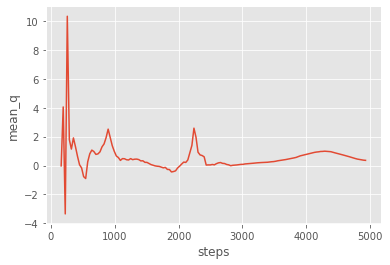

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 87s 88ms/step - reward: 14.0576 - cumulative_reward: -917.5803
train 10 completed. took 821.486 seconds, total_reward: -932.8000000001833 total_profit: 0.7003343745758247
min reward: -160.70000000000027, max reward: 168.70000000000164, mean_reward: -0.18848252172159696


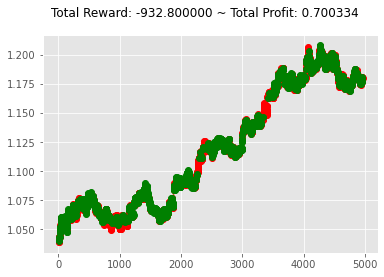

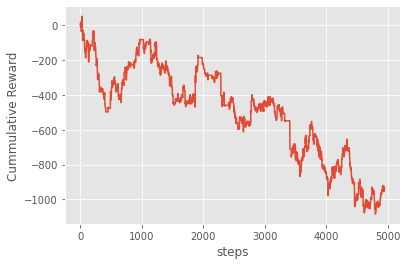

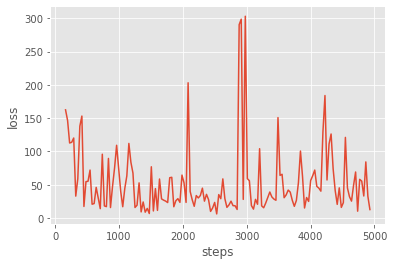

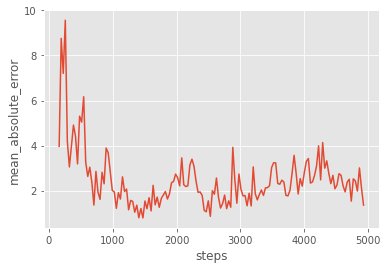

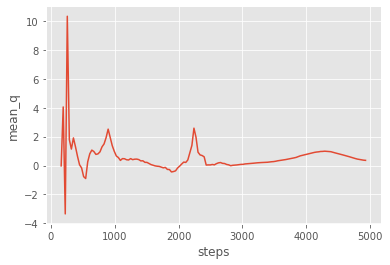

In [7]:
e = Evaluator(agent_creator, env_creator, name="doubledqn")
e.train(repeat=10)

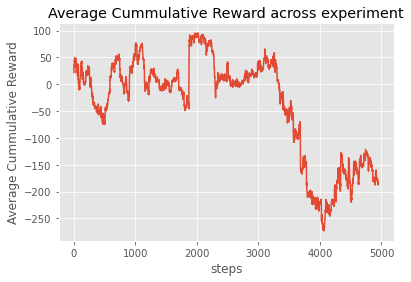

In [8]:
e.process_train_result()

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
196/199 [============================>.] - ETA: 0s - reward: 0.0000e+00 - cumulative_reward: 0.0000e+00Episode 1: reward: 0.000, steps: 999

test completed. total_reward: 0.0 total_profit: 1.0040589181323873
min reward: 0.0, max reward: 0.0, mean_reward: 0.0



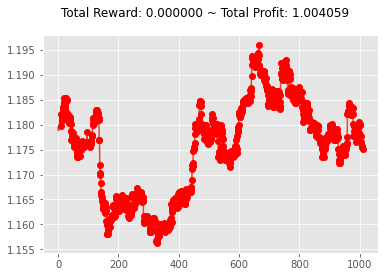

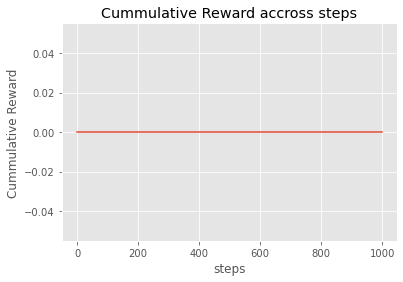

In [9]:
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10))

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 83s 84ms/step - reward: -1.2187 - cumulative_reward: -730.2928
train 1 completed. took 92.916 seconds, total_reward: -1206.3000000000018 total_profit: 0.8110139682943969
min reward: -180.8999999999994, max reward: 149.100000000002, mean_reward: -0.24374621135582983


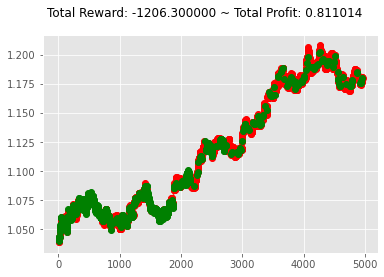

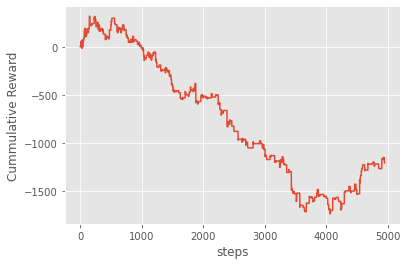

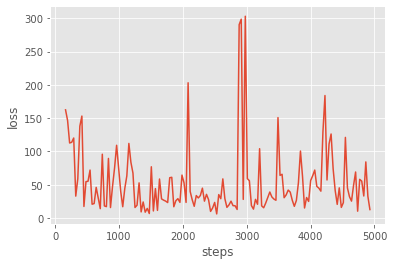

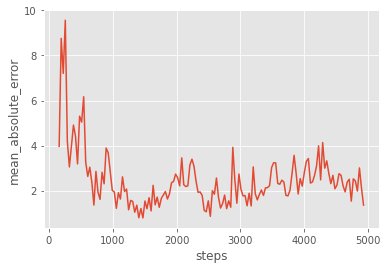

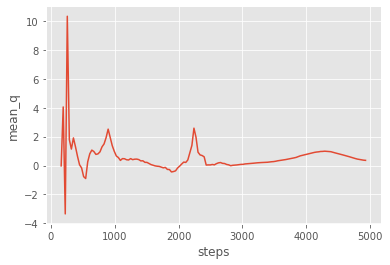

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 85s 86ms/step - reward: 22.1090 - cumulative_reward: 244.6172
train 2 completed. took 192.665 seconds, total_reward: 206.90000000004085 total_profit: 0.883089254393485
min reward: -156.30000000000254, max reward: 197.50000000000156, mean_reward: 0.04180642554052149


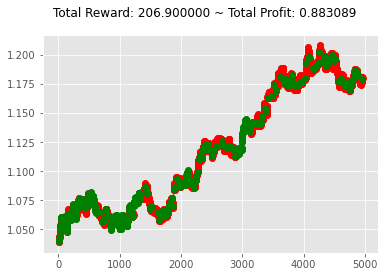

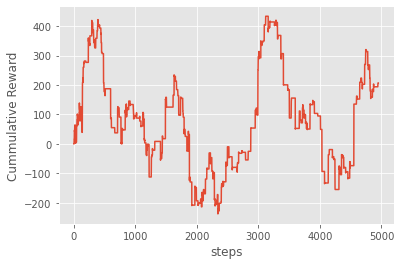

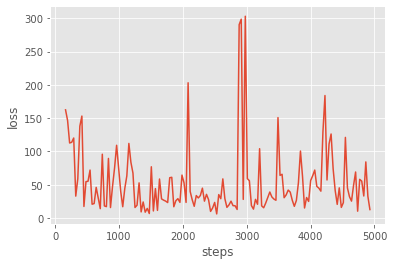

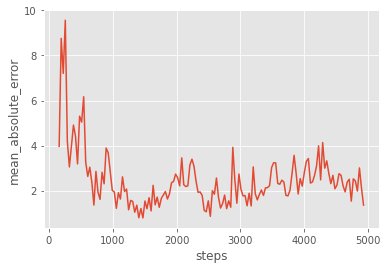

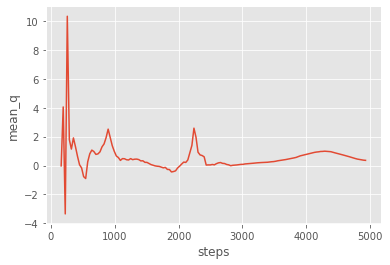

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 88s 89ms/step - reward: -0.4636 - cumulative_reward: -453.3927 3s - reward: -0.4648 - cumulative_reward: -4
train 3 completed. took 296.260 seconds, total_reward: -458.8999999999859 total_profit: 0.8465582201723155
min reward: -195.19999999999982, max reward: 115.7000000000008, mean_reward: -0.0927258031925613


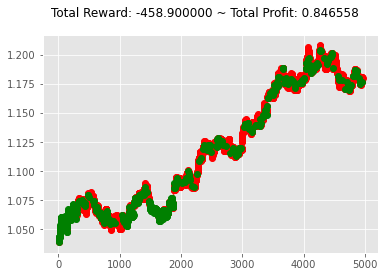

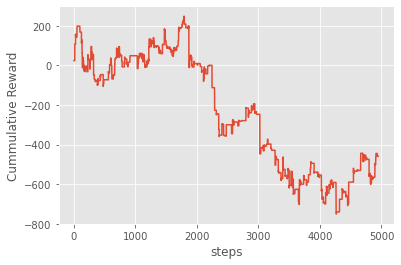

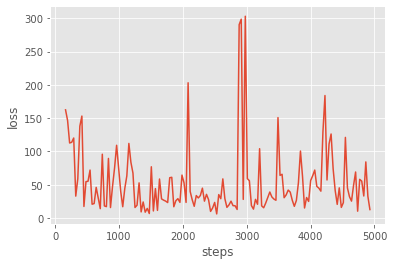

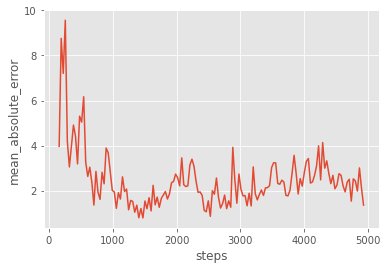

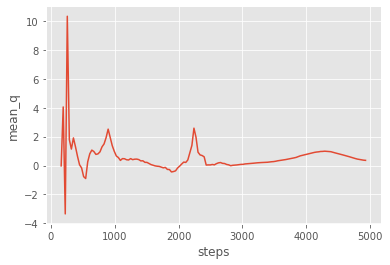

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 91s 92ms/step - reward: -0.9096 - cumulative_reward: -636.1518
train 4 completed. took 404.584 seconds, total_reward: -900.2999999999366 total_profit: 0.8419800174161315
min reward: -170.80000000000206, max reward: 185.9999999999995, mean_reward: -0.18191553849261197


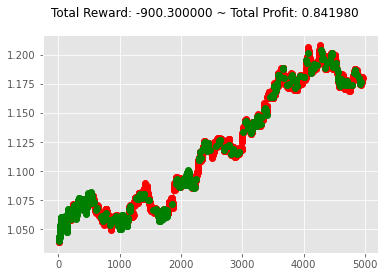

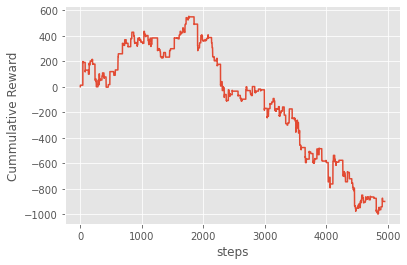

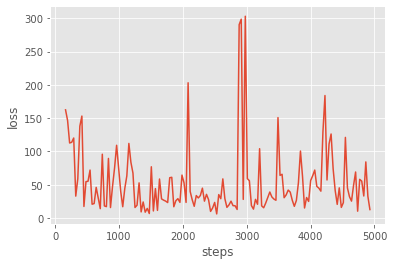

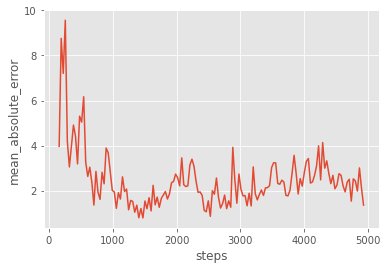

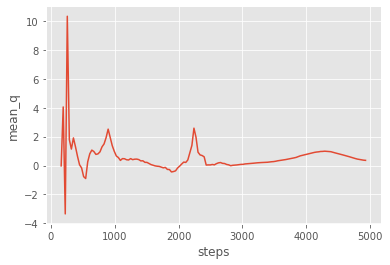

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 84s 85ms/step - reward: 1.0729 - cumulative_reward: 542.9144
train 5 completed. took 507.767 seconds, total_reward: 1061.9999999999604 total_profit: 0.9083835211153626
min reward: -164.70000000000206, max reward: 190.20000000000036, mean_reward: 0.21458880581934944


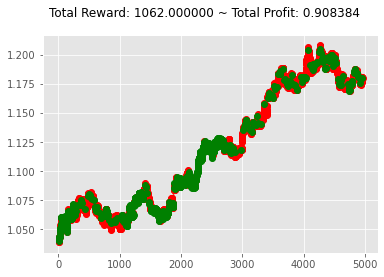

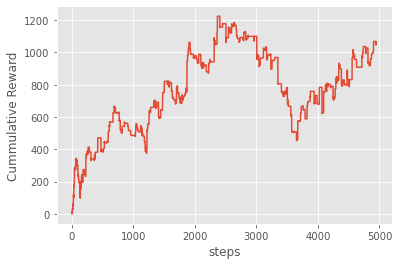

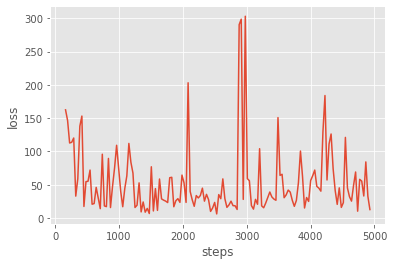

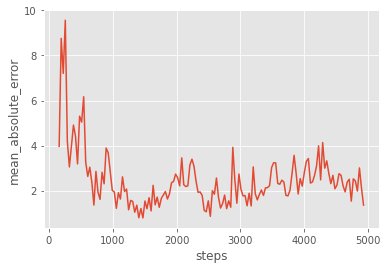

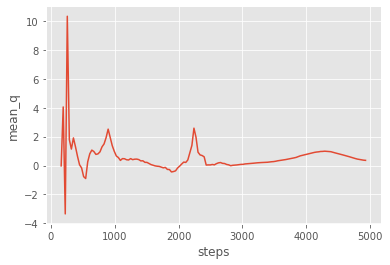

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 110s 111ms/step - reward: -13.5290 - cumulative_reward: -475.5966
train 6 completed. took 633.868 seconds, total_reward: -325.6000000000593 total_profit: 0.8576516888288614
min reward: -156.8999999999998, max reward: 179.39999999999844, mean_reward: -0.06579106890282063


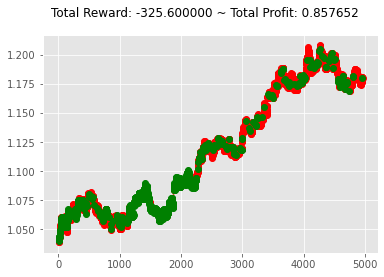

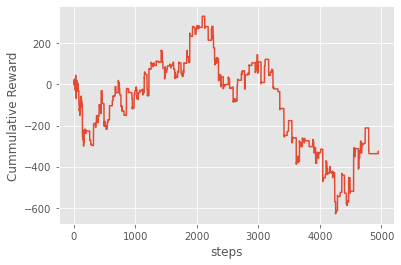

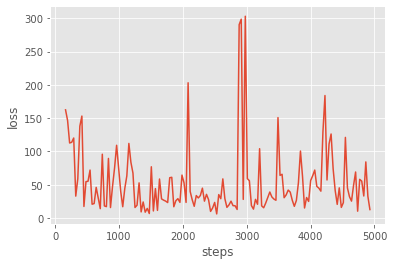

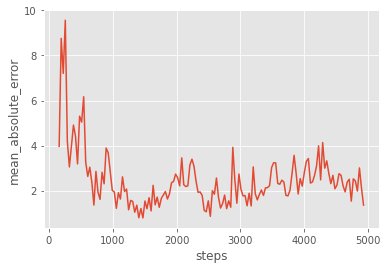

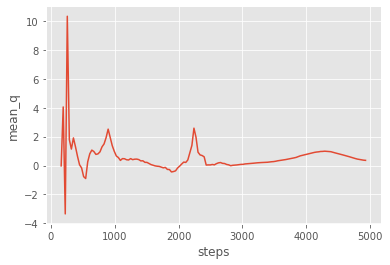

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 91s 92ms/step - reward: -0.5081 - cumulative_reward: -439.6968
train 7 completed. took 746.933 seconds, total_reward: -502.90000000001453 total_profit: 0.8506610053651269
min reward: -244.99999999999966, max reward: 118.10000000000099, mean_reward: -0.10161648817943313


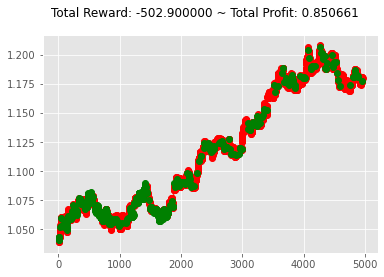

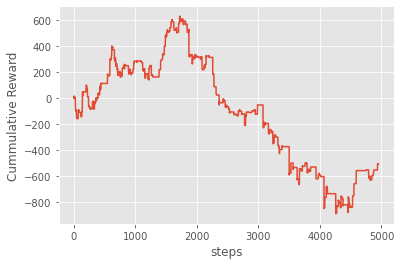

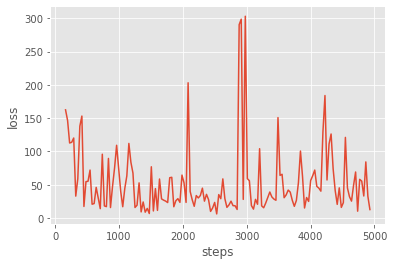

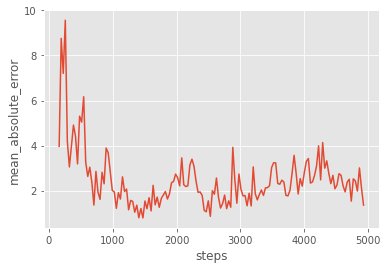

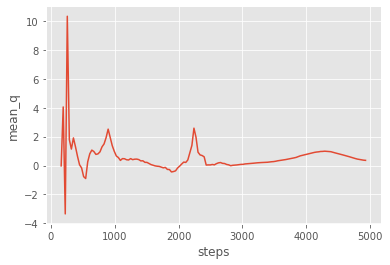

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 94s 95ms/step - reward: -0.9187 - cumulative_reward: -498.3938 23
train 8 completed. took 861.597 seconds, total_reward: -909.2999999999981 total_profit: 0.8435550974225753
min reward: -185.50000000000065, max reward: 177.29999999999802, mean_reward: -0.18373408769448335


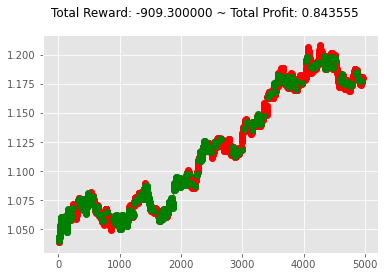

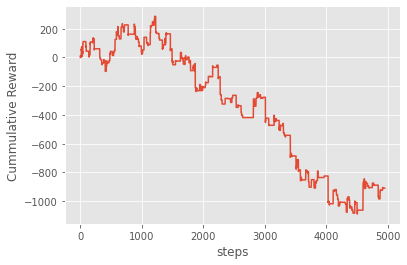

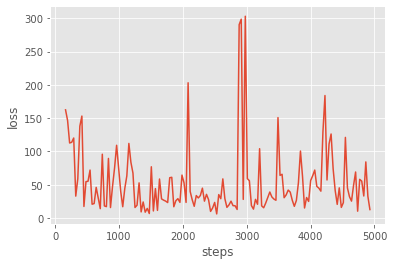

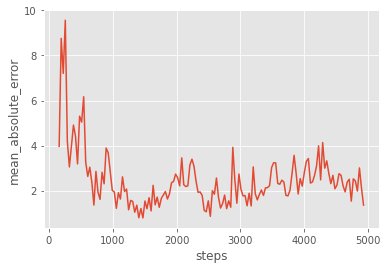

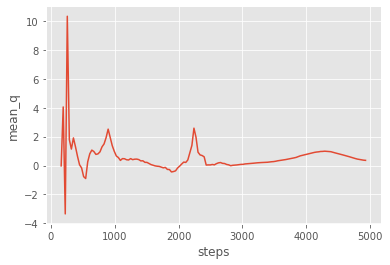

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 111s 112ms/step - reward: 45.1467 - cumulative_reward: -200.84594s - reward: 50.925
train 9 completed. took 990.228 seconds, total_reward: 46.20000000000074 total_profit: 0.8541179739817591
min reward: -164.90000000000117, max reward: 178.70000000000053, mean_reward: 0.009335219236209485


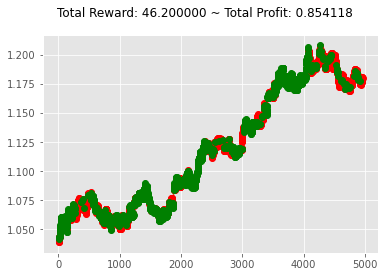

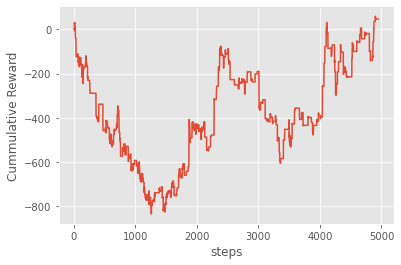

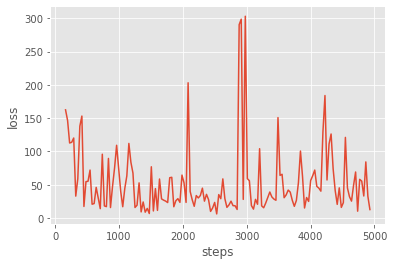

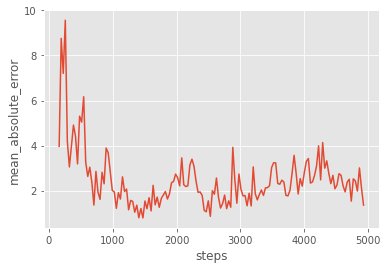

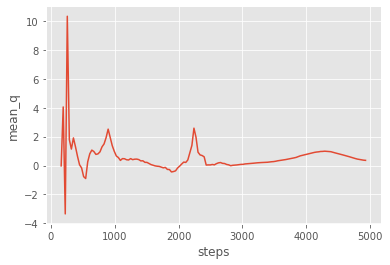

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 92s 93ms/step - reward: 12.6978 - cumulative_reward: 82.1366
train 10 completed. took 1102.276 seconds, total_reward: 591.6999999999398 total_profit: 0.9007351553400947
min reward: -186.30000000000146, max reward: 170.79999999999984, mean_reward: 0.1195595069710931


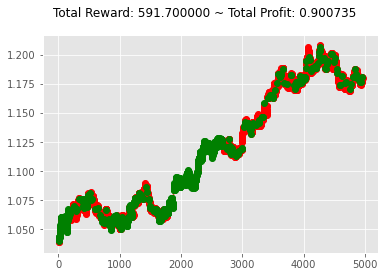

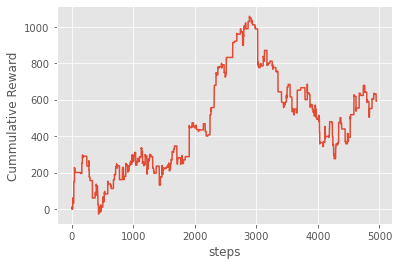

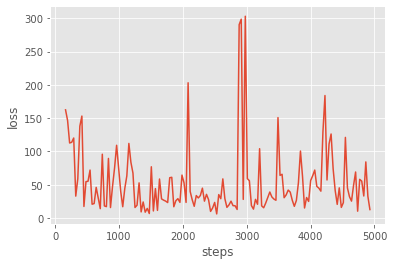

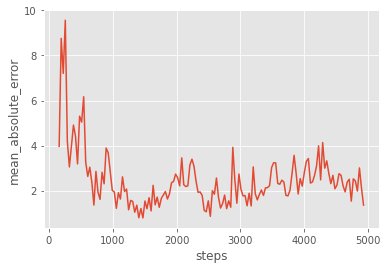

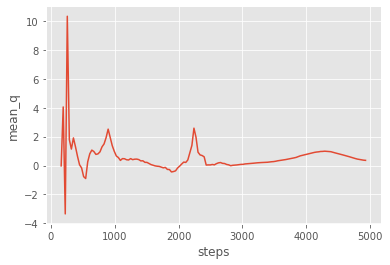

In [16]:
def agent_creator():
    #processor = EnvProcessor()
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=1024, window_length=1)
    policy = EpsGreedyQPolicy()
    #policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, enable_double_dqn=False, enable_dueling_network=True)
    agent.compile(Adam(lr=0.01), metrics=['mae'])
    return agent
e = Evaluator(agent_creator, env_creator, name="dueling_dqn")
e.train(repeat=10)


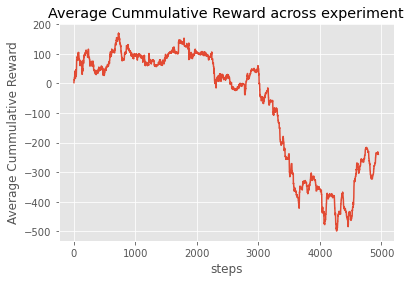

In [ ]:
e.process_train_result()
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10))